<a href="https://colab.research.google.com/github/JMML2021/Entrega-projecte-final/blob/main/3.b%20Companyia%20Aerea%20Algoritmes%20d%E2%80%99aprenentatge%20supervisat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content/drive/MyDrive/Ficheros de Vueling/2022-09-20 14:39:04.960091 FLT_2022.xlsx

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 

%matplotlib inline


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# Configuració warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Activo Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title Obrir fitxer de Github.
#path='/content/drive/MyDrive/2022.06.03 2022_delay + cierre puertas CORTO.xlsx'
Hoja = 'FLT_2022'
path = ('/content/drive/MyDrive/Ficheros de Vueling/2022-09-20 14:39:04.960091 FLT_2022.xlsx')

df = pd.read_excel(path) #, sheet_name=Hoja)


In [116]:
# Para crear una logistic regresion:
# 10 minuts és el temps que s'accepta com arribar a l'hora

df['Tard1'] = np.where(df['Puntualidad1'] <10, 0, 1)
df['Tard2'] = np.where(df['Puntualidad2'] <10, 0, 1)
df['Tard3'] = np.where(df['Puntualidad3'] <10, 0, 1)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12358 entries, 0 to 12357
Data columns (total 97 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Unnamed: 0                       12358 non-null  int64         
 1   DATE                             12358 non-null  datetime64[ns]
 2   FLT                              12358 non-null  object        
 3   REG                              12358 non-null  object        
 4   AC                               12358 non-null  object        
 5   DEP                              12358 non-null  object        
 6   ARR                              12358 non-null  object        
 7   STD                              12358 non-null  datetime64[ns]
 8   STA                              12358 non-null  datetime64[ns]
 9   TKof                             12358 non-null  datetime64[ns]
 10  TDwn                             12358 non-null  datetime6

In [118]:
df[['Puntualidad1','Tard1']][:3]

,Puntualidad1,Tard1
0,15.0,1
1,-22.0,0
2,3.0,0


Només treballaré en els factors importants que crec afecten l'Error en puntualitat del 3r salt.



---



In [119]:
#@title crec el DataFrame df1
df1=df[['Puntualidad1', 'Puntualidad2', 'Puntualidad3', 
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3', 'Tard1', 'Tard2', 'Tard3']]

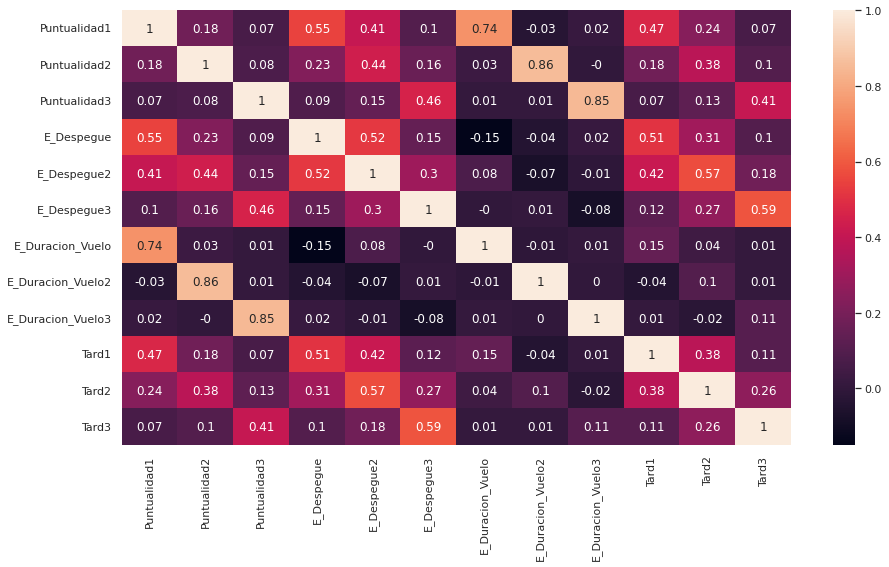

In [120]:
#@title Crec la matriu de correlació entre tots  els factors importants.

correlation_matrix = df1.corr().round(2) 
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data=correlation_matrix, annot=True)

In [121]:
#@#@title Estandarditzar les característiques eliminant la mitjana i escalant a la variància de la unitat.

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler

mapper = DataFrameMapper([(df1.columns, StandardScaler())])
scaled_features = mapper.fit_transform(df1.copy(), 4)
df1_StdScaler= pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)

df1_StdScaler.head()

,Puntualidad1,Puntualidad2,Puntualidad3,E_Despegue,E_Despegue2,E_Despegue3,E_Duracion_Vuelo,E_Duracion_Vuelo2,E_Duracion_Vuelo3,Tard1,Tard2,Tard3
0,0.661875,0.158984,-0.020942,1.006091,0.398530,-0.039738,-0.022665,-0.049533,0.000086,2.979681,-0.387587,-0.362741
1,-0.620447,-0.405877,-0.020942,-0.939568,-0.840450,-0.655431,0.018437,0.025896,0.365863,-0.335606,-0.387587,-0.362741
2,0.245987,0.204173,-0.169253,0.340471,0.133034,-0.095710,0.018437,0.151611,-0.132924,-0.335606,-0.387587,-0.362741
3,0.800504,0.000823,-0.525200,1.159696,0.575527,-0.543487,0.018437,-0.326106,-0.265933,2.979681,-0.387587,-0.362741
4,0.176672,-0.134744,-0.050604,-0.222746,-0.530705,-0.263626,0.388352,0.151611,0.099843,-0.335606,-0.387587,-0.362741


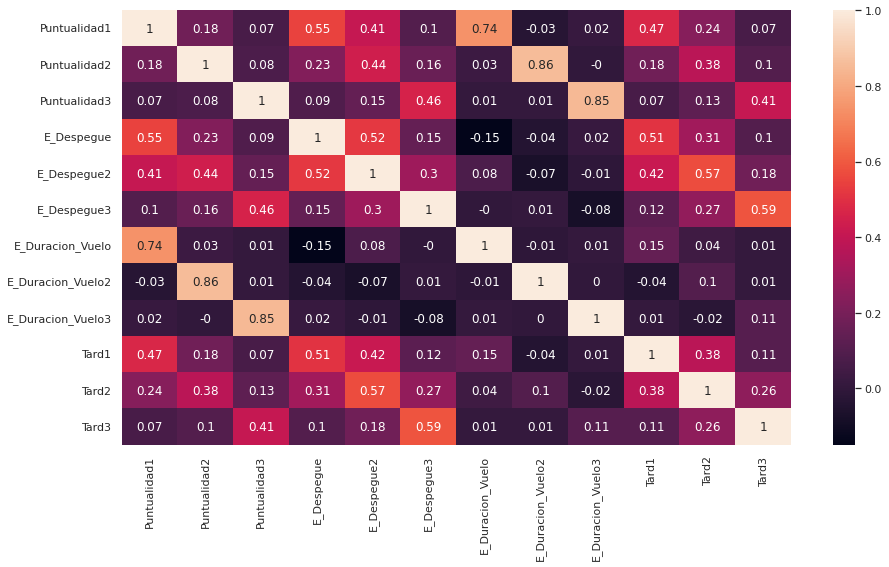

In [122]:
# Crec la matriu de correlació entre tots  els factors importants després d'estar normalitzat.

correlation_matrix = df1_StdScaler.corr().round(2) 
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data=correlation_matrix, annot=True)

No hi veig diferències en les correlacions després de la normalització dels valors

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7490f83dd0>,
      dtype=object)

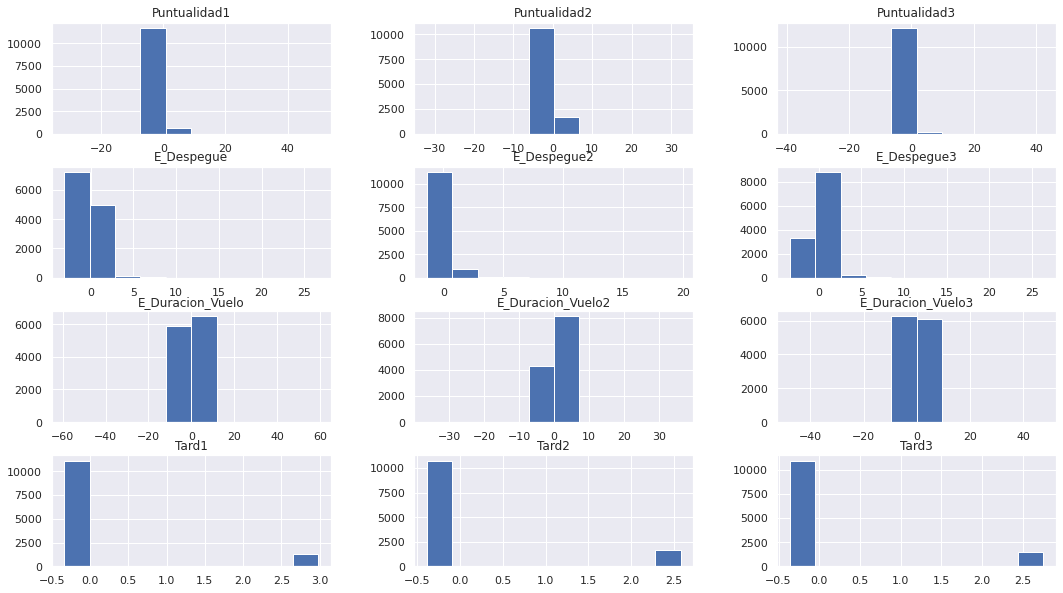

In [123]:
# Con los datos transformados veo si ha cambiado mucho la forma de cada variable
df1_StdScaler[df1_StdScaler.columns].hist(figsize=(18,10))

Veig que els outliers (> o < 30 minuts) afecten molt a la gràfica.


---



# Trec els outliers

In [124]:
df1.head()

,Puntualidad1,Puntualidad2,Puntualidad3,E_Despegue,E_Despegue2,E_Despegue3,E_Duracion_Vuelo,E_Duracion_Vuelo2,E_Duracion_Vuelo3,Tard1,Tard2,Tard3
0,15.0,4,-5,20,11,0.0,-5.0,-7,-5.0,1,0,0
1,-22.0,-21,-5,-18,-17,-11.0,-4.0,-4,6.0,0,0,0
2,3.0,6,-10,7,5,-1.0,-4.0,1,-9.0,0,0,0
3,19.0,-3,-22,23,15,-9.0,-4.0,-18,-13.0,1,0,0
4,1.0,-9,-6,-4,-10,-4.0,5.0,1,-2.0,0,0,0


In [125]:
#@title Elimino els outliers
df2=df1.copy()

dfEliminarOutliers= ((df2['E_Despegue']> -30) & 
                     (df2['E_Despegue']< 30) & 
                     (df2['Puntualidad1']< 30) & 
                     (df2['Puntualidad1']>-30) &
                     (df2['Puntualidad2']< 30) & 
                     (df2['Puntualidad2']>-30)&
                     (df2['E_Despegue2']< 30) & 
                     (df2['E_Despegue2']>-30)&
                     (df2['Puntualidad3']< 30) & 
                     (df2['Puntualidad3']>-30)&
                     (df2['E_Despegue3']< 30) & 
                     (df2['E_Despegue3']>-30))

df2 = df2[dfEliminarOutliers]

In [126]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10708 entries, 0 to 12357
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Puntualidad1       10708 non-null  float64
 1   Puntualidad2       10708 non-null  int64  
 2   Puntualidad3       10708 non-null  int64  
 3   E_Despegue         10708 non-null  int64  
 4   E_Despegue2        10708 non-null  int64  
 5   E_Despegue3        10708 non-null  float64
 6   E_Duracion_Vuelo   10708 non-null  float64
 7   E_Duracion_Vuelo2  10708 non-null  int64  
 8   E_Duracion_Vuelo3  10708 non-null  float64
 9   Tard1              10708 non-null  int64  
 10  Tard2              10708 non-null  int64  
 11  Tard3              10708 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 1.1 MB


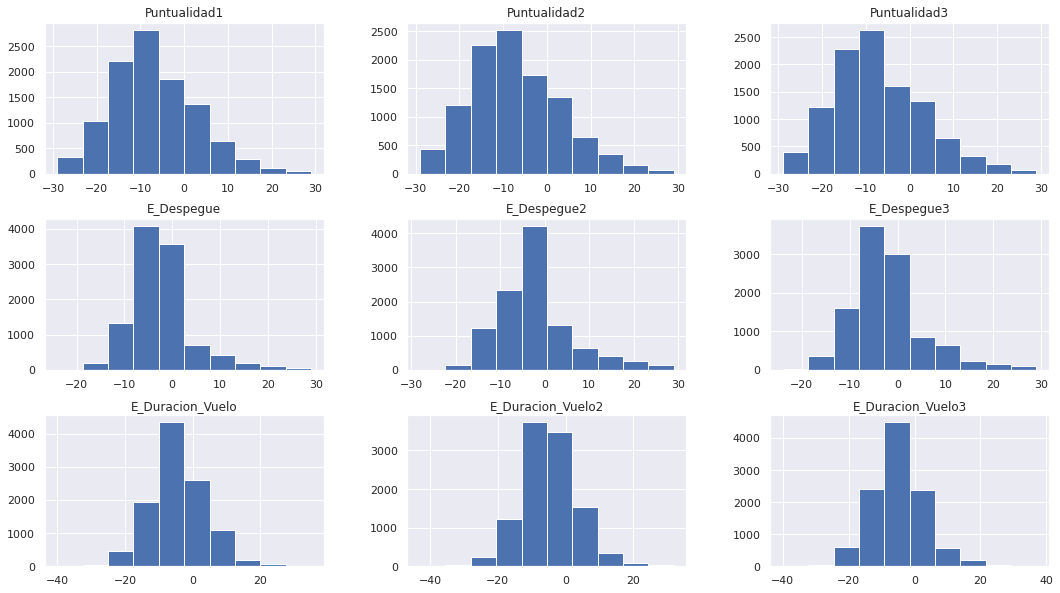

In [127]:
# Amb les dades transformades veig si ha canviat molt la forma de cada variable

ax= df2[df2.columns[:-3]].hist(figsize=(18,10))
 

Jose Manuel Castaño.

desbanceado = sampling 
Diferencia de accuracy y precision.

RobustScaler dummies
gradien boosting clasificaier
aplicar el cross validation
random forest e sbueno para los desbalanceados

finaldf= pd.concat([principal_Df,df[['target']]],axis=1)

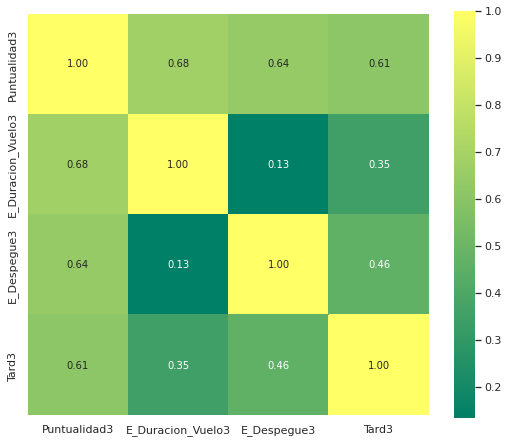

In [128]:
#@title quines variables tenen més correlació respecte al target (tard 3)
# Vull veure quines variables tenen més correlació respecte al target (tard 3)

columns_sorted = df2.corr().abs().nlargest(4, 'Puntualidad3').index
correlation_sorted = np.corrcoef(df2[columns_sorted].values.T)

f, ax = plt.subplots(figsize = (9,7.5))
hm = sns.heatmap(abs(correlation_sorted), annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns_sorted.values, xticklabels=columns_sorted.values, cmap='summer')
plt.show()

In [129]:
# Creo Subrutina de metricas:

#Importo scikit-learn metrics module para el calculo
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
metricasEjercicio2=[]
######################################################################
 
def MetricasModelo(metodo, Y_real, Y_calculado, scores):
  print('Metodo: ', metodo)
  
  #Precisión del modelo: ¿con qué frecuencia es correcto el clasificador?
  #accuracy = metrics.accuracy_score(Y_real, Y_calculado)
  #print("Accuracy:", accuracy)

  rmse = np.sqrt(mean_squared_error(Y_real, Y_calculado,))
  print("RMSE: %f" % (rmse))
  

  R_squared = r2_score(Y_real, Y_calculado,)

  print("R-Squared: ", np.round(R_squared, 2))
 
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  accuracy = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

  # Guardo metricas
  metricasEjercicio2.append([metodo, rmse, R_squared, accuracy])  


  cnf_matrix_SVM = metrics.confusion_matrix(Y_real, Y_calculado)

  print('\n\nMatriz de Confusión')
  print(cnf_matrix_SVM)


  # Creamos la Matriz de Confusion:

  class_names=[0,1] # name  of classes
  
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  # create heatmap

  sns.heatmap(pd.DataFrame(cnf_matrix_SVM), annot=True, cmap="gist_ncar" ,fmt='g')
  ax.xaxis.set_label_position("top")
 

  plt.tight_layout()
  plt.title('Matriu de confusió', y=1.1)
  plt.ylabel('Valor Actual')
  plt.xlabel('Valor predit')
  plt.Text(1.5,257.44,'Predicció')


# Regresión logística con Python

https://www.cienciadedatos.net/documentos/py17-regresion-logistica-python.html

In [130]:
# Número de obsercaciones por clase
# ==============================================================================
df2['Tard3'].value_counts().sort_index()

0    9950
1     758
Name: Tard3, dtype: int64

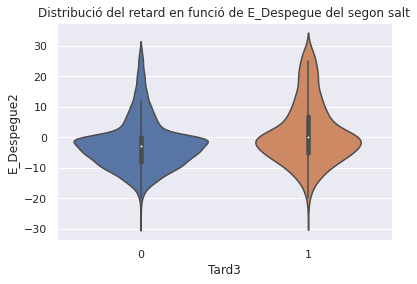

In [131]:
#@title Gráfic distribució del retard-3 en funció de E_Despegue del segon salt
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 4))

sns.violinplot(
        x     = 'Tard3',
        y     = 'E_Despegue2',
        data  = df2,
        #color = "white",
        ax    = ax
    )

ax.set_title('Distribució del retard en funció de E_Despegue del segon salt');

In [183]:
#@title T-test entre classes
# ==============================================================================
from statsmodels.stats.weightstats import ttest_ind


res_ttest = ttest_ind(
                x1 = df2[df2['Tard3'] == 0],
                x2 = df2[df2['Tard3'] == 1],
                alternative='two-sided'
            )
#print(f"t={res_ttest[0]}, p-value={res_ttest[1]}")

print('t_test  =', round(res_ttest[1].mean(),3))

t_test  = 0.001



Tant el gràfic com el t-test mostren evidències que hi ha una diferència entre l'error en el retard i l'error en l'enlairament. Aquesta informació és útil per considerar l'error en l'enlairament com un bon predictor per al model.

## Considerem només una variable (Error en l'enlairament de l'anterior salt)

In [135]:
# Importo train_test_split function para dividir los datos en Test y Train

from sklearn.model_selection import train_test_split

datos_x= df2.loc[:, ['E_Despegue2']].values
datos_y = df2.loc[:,['Tard3']].values

#Dividimos el dataset en training set y test set
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.3,random_state=109) # 70% training i 30% test

In [136]:
import statsmodels.api as sm

modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary2())

Optimization terminated successfully.
         Current function value: 0.660201
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: -1.540   
Dependent Variable: y                AIC:              9898.4123
Date:               2022-10-04 07:55 BIC:              9905.3343
No. Observations:   7495             Log-Likelihood:   -4948.2  
Df Model:           0                LL-Null:          -1948.1  
Df Residuals:       7494             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
-------------------------------------------------------------------
        Coef.     Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1      0.0633      0.0030    21.0440    0.0000    0.0574    0.0692



Ens dona un valor molt baix de R-squared:, vol dir que no influeix. 

És **estadísticament** significatiu (p-value =0), però no *pràcticament* significatiu.


---



In [137]:
X_train

array([[-1],
       [-5],
       [ 7],
       ...,
       [-5],
       [-1],
       [-5]])

In [138]:
# Predicción de probabilidades
# ==============================================================================
predicciones = modelo.predict(exog = X_train)
predicciones[:4]

array([0.4841688 , 0.42147291, 0.60907408, 0.53163069])

In [139]:
# instanciar el modelo (usando los parámetros predeterminados)

from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression()


# fit el modelo
logreg.fit(X_train,y_train)

#
y_pred_RLogis=logreg.predict(X_test)

In [140]:
#@title Cross_val_score


#Cross_val_score és una funció del paquet scikit-learn que entrena i prova un model en diversos plecs 
#del vostre conjunt de dades. Aquest mètode de validació creuada us ofereix una millor comprensió del rendiment 
# del model a tot el conjunt de dades en lloc d'una sola divisió de tren/prova.


scores_RL = cross_val_score(logreg, X_train, y_train, cv=5)
 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RL.mean(), scores_RL.std() * 2))

Accuracy: 0.93 (+/- 0.00)


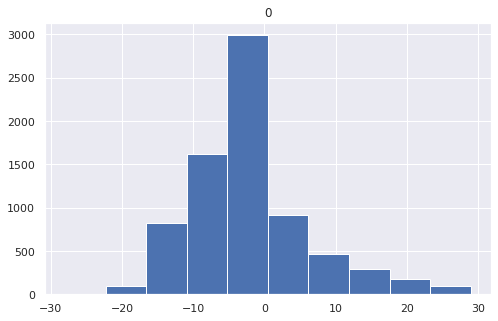

In [141]:
X_train= pd.DataFrame(X_train)
ax= X_train.hist(figsize=(8,5))

In [142]:
X_test.shape

(3213, 1)

In [143]:
# NO FUNCIONA


# Accuracy de test del model
# ==============================================================================
#X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
clasificacion = np.where(predicciones<0.5, 0, 1)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = clasificacion,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 66.69779022720199%


In [144]:
#Borrar
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.3,random_state=109) # 70% training and 30% test
# instanciar el modelo (usando los parámetros predeterminados)
logreg = LogisticRegression()

# fit el modelo
logreg.fit(X_train,y_train)

#
y_pred_RLogis=logreg.predict(X_test)

In [145]:
# Predicciones en todo el rango de X
# ==============================================================================
# Se crea un vector con nuevos valores interpolados en el rango de observaciones.

grid_X = np.linspace(
            start = min(df2.E_Despegue2),
            stop  = max(df2.E_Despegue2),
            num   = 200
         ).reshape(-1,1)

grid_X = sm.add_constant(grid_X, prepend=True)
predicciones = modelo.predict()

In [147]:
# Creación del modelo
# ==============================================================================
# Para no incluir ningún tipo de regularización en el modelo se indica
# penalty='none'

modelo = logreg.predict(X_test)
#modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

In [148]:
X_test.shape

(3213, 1)

# 3.- Gestió unbalance dataset

https://elitedatascience.com/imbalanced-classes

## Regressió Logística Balanceada

In [149]:
#@title Número de obsercacions per clase
# ==============================================================================
df2['Tard3'].value_counts().sort_index()

0    9950
1     758
Name: Tard3, dtype: int64

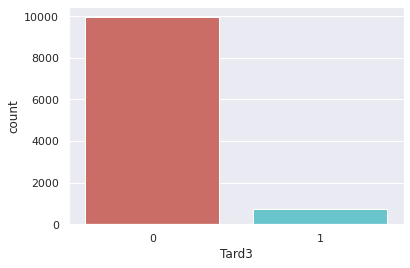

In [348]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=df2, palette='hls')
plt.show()

Veiem que les vols que arriben a l'hora v els que arriben tard és totalment desproporcionat, i per això diem que està des-balancejat.


---




In [151]:
df2.columns

Index(['Puntualidad1', 'Puntualidad2', 'Puntualidad3', 'E_Despegue',
       'E_Despegue2', 'E_Despegue3', 'E_Duracion_Vuelo', 'E_Duracion_Vuelo2',
       'E_Duracion_Vuelo3', 'Tard1', 'Tard2', 'Tard3'],
      dtype='object')

In [152]:
#@title creem df2_sobremostrejat

from sklearn.utils import resample


# Classes majoritàries i minoritàries separades
df_majority = df2[df2.Tard3==0]
df_minority = df2[df2.Tard3==1]
 
# Upsample minority class
df_minority_sobremostrejat = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combina la classe majoritària amb la classe minoritària sobremostrejat
df2_sobremostrejat = pd.concat([df_majority, df_minority_sobremostrejat])

#Mostra els nous recomptes de classes
# 
df2_sobremostrejat.Tard3.value_counts()
 

0    9950
1    8000
Name: Tard3, dtype: int64

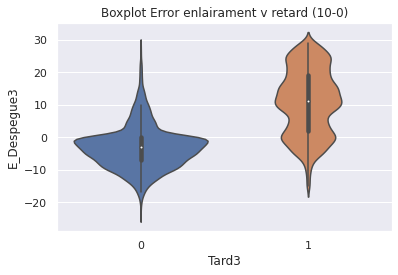

In [153]:
#@title  Boxplot Error enlairament 3r salt v Error arribada.

fig, ax = plt.subplots(figsize=(6, 3.84))

sns.violinplot(
        x     = 'Tard3',
        y     = 'E_Despegue3',
        data  = df2_sobremostrejat,
        #color = "white",
        ax    = ax
    )

ax.set_title('Boxplot Error enlairament v retard (10-0)');

Veiem que hi ha correlació si l'avió surt tard en el tercer enlairament, hi haurà un retard en l'arribada.


---



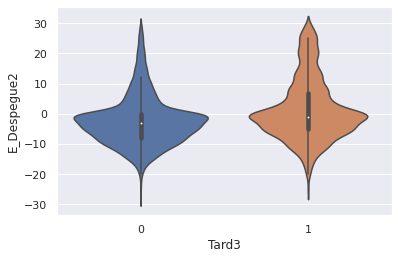

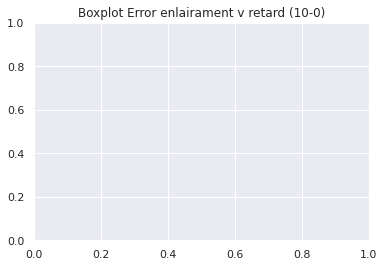

In [347]:
#@title Boxplot E arribada 3r salt v Error enlairament 2n salt
fig, ax = plt.subplots(figsize=(6, 3.84))
sns.violinplot(
        x     = 'Tard3',
        y     = 'E_Despegue2',
        data  = df2_sobremostrejat,
        #color = "white",
        ax    = ax
    )
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Boxplot Error enlairament v retard (10-0)');


Clarament, veiem que **NO** hi ha correlació clara entre en l'enlairament del 2n salt i el retard que té l'avió en el 3r salt.


---



Accuracy: 1.00 (+/- 0.00)
Metodo:  Regr.Log. des-Balancejada
RMSE: 0.000000
R-Squared:  1.0
Accuracy: 1.00 (+/- 0.00)


Matriz de Confusión
[[3009    0]
 [   0 2376]]


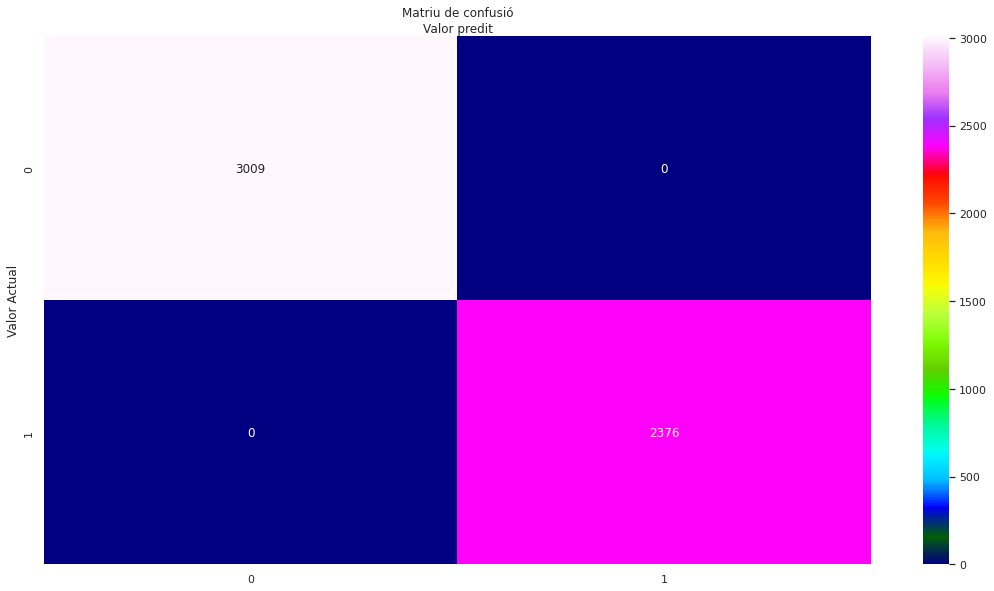

In [155]:
#@title Importo train_test_split function per dividir les dades en Test i Train
from sklearn.model_selection import train_test_split


#@title Crec la columna X e Y: 

datos_x= df2_sobremostrejat.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3','E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values

datos_y = df2_sobremostrejat.loc[:,['Tard3']].values

#Dividims el dataset en training set y test set
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.3,random_state=109) # 70% training and 30% test


# instanciem el model (fem servir els paràmetres predeterminats)
logreg = LogisticRegression()

# fit el model
logreg.fit(X_train,y_train)

#
y_pred_RLogis=logreg.predict(X_test)

scores_RL = cross_val_score(logreg, X_train, y_train, cv=5)
 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RL.mean(), scores_RL.std() * 2))


MetricasModelo( 'Regr.Log. des-Balancejada', y_test, y_pred_RLogis, scores_RL)



Si fiquem tots el parametres de entrada veiem un overfitting.


---



# Regresión logística múltiple

In [156]:

X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [157]:
# Creació del model utilitzant matrius com a scikitlearn
# ================================================= =============================
# A la matriu de predictors cal afegir una columna de 1s per a l'intercept del model

import statsmodels.api as sm

# Divisió de les dades en train i test
# ==============================================================================
datos_x= df2_sobremostrejat.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 

X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )


In [158]:
#X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(y_train, X_train,)
modelo = modelo.fit()
print(modelo.summary())

         Current function value: 0.146195
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14360
Model:                          Logit   Df Residuals:                    14354
Method:                           MLE   Df Model:                            5
Date:                Tue, 04 Oct 2022   Pseudo R-squ.:                  0.7872
Time:                        07:55:36   Log-Likelihood:                -2099.4
converged:                      False   LL-Null:                       -9865.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0661        nan        nan        nan         nan         nan
x2             0.0273        nan        nan        nan         na

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


# 3.- Regresion Logistica Balanceada Binomial

In [159]:
df2_sobremostrejat.shape

(17950, 12)

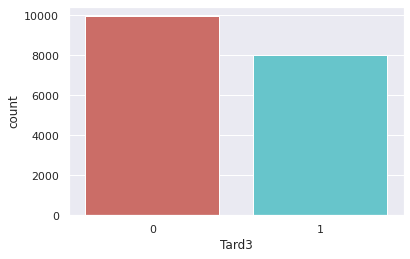

In [346]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=df2_sobremostrejat, palette='hls')
plt.show()

In [161]:
datos_x= df2_sobremostrejat.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]]

datos_y = df2_sobremostrejat.loc[:,['Tard3']]

https://www.statsmodels.org/stable/index.html

In [162]:
#@title Creem el model de regressió logística.(totes les variables) per veure quines variables afecten

import statsmodels.api as sm

logit_model=sm.Logit( datos_y, datos_x)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.147017
         Iterations: 35
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.786    
Dependent Variable: Tard3            AIC:              5289.9023
Date:               2022-10-04 07:55 BIC:              5336.6744
No. Observations:   17950            Log-Likelihood:   -2639.0  
Df Model:           5                LL-Null:          -12336.  
Df Residuals:       17944            LLR p-value:      0.0000   
Converged:          0.0000           Scale:            1.0000   
No. Iterations:     35.0000                                     
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Puntualidad1        0.0653      nan     nan    nan    nan    nan
Puntualidad2        0.0276      nan     nan    nan    nan    nan
E_Despegue          0.0240      nan     nan    na

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


**Qué diferencia** hay entre print(results.summary()) y print(results.summary2())

In [163]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  Tard3   No. Observations:                17950
Model:                          Logit   Df Residuals:                    17944
Method:                           MLE   Df Model:                            5
Date:                Tue, 04 Oct 2022   Pseudo R-squ.:                  0.7861
Time:                        07:55:36   Log-Likelihood:                -2639.0
converged:                      False   LL-Null:                       -12336.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Puntualidad1          0.0653        nan        nan        nan         nan         nan
Puntualidad2          0.0276        nan        nan        nan         nan         nan
E_Despegue            0.

Veiem que només l'error en l'enlairament de l'avió i l'Error en el temps de vol, afecten com factors a la variable de sortida Error en l'arribada.


---



In [164]:
#@title model amb 'E_Despegue3', 'E_Duracion_Vuelo3' només.

cols=['E_Despegue3', 'E_Duracion_Vuelo3']
#cols=['E_Despegue3'] # Per crear una mica error
X=datos_x[cols]
y=datos_y


logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.194775
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.717    
Dependent Variable: Tard3            AIC:              6996.4355
Date:               2022-10-04 07:55 BIC:              7012.0262
No. Observations:   17950            Log-Likelihood:   -3496.2  
Df Model:           1                LL-Null:          -12336.  
Df Residuals:       17948            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
E_Despegue3         0.2857   0.0047 61.0477 0.0000 0.2765 0.2948
E_Duracion_Vuelo3   0.3126   0.0056 56.2014 0.0000 0.3017 0.3235



Aquest model està explicat amb un 71%

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.193130
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.719    
Dependent Variable: Tard3            AIC:              4857.3689
Date:               2022-10-04 07:55 BIC:              4872.2463
No. Observations:   12565            Log-Likelihood:   -2426.7  
Df Model:           1                LL-Null:          -8626.8  
Df Residuals:       12563            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
E_Despegue3         0.2866   0.0056 51.3298 0.0000 0.2756 0.2975
E_Duracion_Vuelo3   0.3214   0.0069 46.7525 0.0000 0.3080 0.3349



In [166]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================

# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo

X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

         Current function value: 0.000152
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Tard3   No. Observations:                12565
Model:                          Logit   Df Residuals:                    12562
Method:                           MLE   Df Model:                            2
Date:                Tue, 04 Oct 2022   Pseudo R-squ.:                  0.9998
Time:                        07:55:37   Log-Likelihood:                -1.9054
converged:                      False   LL-Null:                       -8626.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -101.8221     13.932     -7.309      0.000    -129.128     -74.516
E_Despegue3          10.8262      1.460     

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [167]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

         Current function value: 0.000152
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Tard3   No. Observations:                12565
Model:                          Logit   Df Residuals:                    12562
Method:                           MLE   Df Model:                            2
Date:                Tue, 04 Oct 2022   Pseudo R-squ.:                  0.9998
Time:                        07:55:37   Log-Likelihood:                -1.9054
converged:                      False   LL-Null:                       -8626.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -101.8221     13.932     -7.309      0.000    -129.128     -74.516
E_Despegue3          10.8262      1.460     

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [168]:
# Predicciones con intervalo de confianza 
# ==============================================================================
predicciones = modelo.predict(exog = X_train)

# Clasificación predicha
# ==============================================================================
clasificacion = np.where(predicciones<0.5, 0, 1)
clasificacion

array([0, 0, 0, ..., 0, 1, 0])

In [169]:
# Accuracy de test del modelo 
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
clasificacion = np.where(predicciones<0.5, 0, 1)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = clasificacion,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 100.0%


In [170]:
#@title Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.values.ravel(),
    clasificacion,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0,1
Real,,
0,2948,0
1,0,2437




---



Busquem la correlacion entre variables 'E_Despegue3' i 'E_Duracion_Vuelo3', i el tamany que és en funció del temps de retard.

# Regresión logística simple. 'E_Despegue3','E_Duracion_Vuelo3'

In [184]:
datos_x= df2_sobremostrejat.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]]

datos_y = df2_sobremostrejat.loc[:,['Tard3']]

cols=['E_Despegue3','E_Duracion_Vuelo3']
#cols=['E_Despegue3'] # Per crear una mica error
X=datos_x[cols]
y=datos_y


logit_model=sm.Logit(y,exog = X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.194775
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.717    
Dependent Variable: Tard3            AIC:              6996.4355
Date:               2022-10-04 08:02 BIC:              7012.0262
No. Observations:   17950            Log-Likelihood:   -3496.2  
Df Model:           1                LL-Null:          -12336.  
Df Residuals:       17948            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
E_Despegue3         0.2857   0.0047 61.0477 0.0000 0.2765 0.2948
E_Duracion_Vuelo3   0.3126   0.0056 56.2014 0.0000 0.3017 0.3235



In [185]:
y_pred = result.predict(X)

# Predicció:

Un cop entrenat el model, es poden obtenir prediccions per a noves dades. Els models de regressió logística de statsmodels tornen la probabilitat de pertànyer a la classe de referència.

In [311]:
# Predicción de probabilidades
# ==============================================================================
predicciones = result.predict(exog = X)
predicciones[:4]

0    0.173249
1    0.219781
2    0.043163
3    0.001313
dtype: float64

In [174]:
# Clasificación predicha
# ==============================================================================
clasificacion = np.where(predicciones<0.5, 0, 1)
clasificacion

array([1, 0, 0, ..., 1, 1, 1])

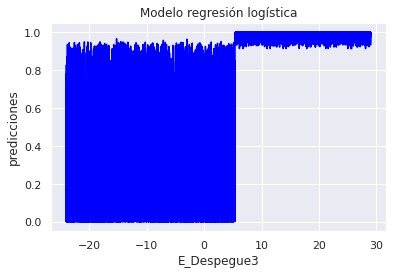

In [316]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(grid_X['grid_X'], predicciones, color = "blue")
ax.set_title("Modelo regresión logística")
ax.set_ylabel("prediccions")
ax.set_xlabel("E_Despegue3");

Es veu clarament que les probabilitats d'arribar a l'hora és molt alta.

---



Optimization terminated successfully.
         Current function value: 0.476043
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.307     
Dependent Variable: Tard3            AIC:              17091.9550
Date:               2022-10-04 10:07 BIC:              17099.7503
No. Observations:   17950            Log-Likelihood:   -8545.0   
Df Model:           0                LL-Null:          -12336.   
Df Residuals:       17949            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
E_Despegue3      0.1775    0.0028  62.6566  0.0000  0.1719  0.1830



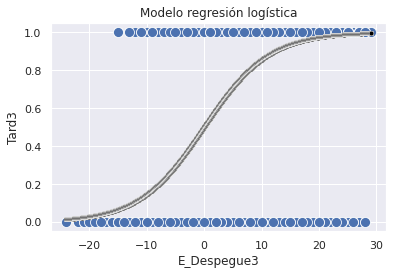

In [345]:

#@title Dibuixem la regressió logística només per E_Despegue3 (error en l'enlairament)

cols=['E_Despegue3','E_Duracion_Vuelo3']
cols=['E_Despegue3'] # Per crear una mica error
X=datos_x[cols]
y=datos_y
logit_model=sm.Logit(y,exog = X)
 

grid_X = np.linspace(
            start = min(X.E_Despegue3),
            stop  = max(X.E_Despegue3),
            num   =  predicciones.shape[0] #200
         ).reshape(-1,1)


grid_X=pd.DataFrame(grid_X)
predicciones = result.predict(exog = grid_X)

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.set_title("Modelo regresión logística")
ax=sns.scatterplot(data = df2, x = "E_Despegue3", y = "Tard3", s=100)
ax=sns.scatterplot( x = grid_X[0], y = predicciones, s=20, color='black')

result=logit_model.fit()
print(result.summary2())

**Conclusió:**

Clarament, veiem que és una regressió logística, que el seu valor de correlació és baix. En aquest cas és de 0,3, i per això explica molt poc amb una sola variable. 

Per afirmar bé el model pel retard del 3r salt, hem de fer servir 2 variables (E_Duracion_Vuelo2, E_Despegue3) i arribaré a afirmar en un 0.72 què succeirà.

És molt poc i s'arriba a una conclusió lògica, si l'avió surt tard i volan triga més del planificat, arribarà tard. Però és molt important veure que el que ha passat en els 2 salts anteriors no afecta pràcticament res al salt 3r.

 Independentment de si han surtit o volant, no han tingut una demora superior a 30 minuts que és el que considerem un vol "normal", en els 2 salts anteriors.



Aquesta asseveració és el punt crític del projecte. 

Hem demostrat que els salts són independents entre si. Un retard a un avió és degut a moltes causes, que són variables independents que afecten i que moltes són alienes a la mateixa companyia (exògenes)... però el primer salt és el que menys causes té i que pot controlar-les, perquè per exemple no hi ha retards amb altres interconnexions, o passatgers que han de buscar la maleta, canvis de porta que desorienten als passatgers, etc.

Llavors el que hem d'analitzar és el valor del primer salt, enlairament 1r i analitzar les causes de per què el 99% dels vols no surten a la seva hora. I sortir a l'hora és sortir a <0 minuts, no a <10 minuts.

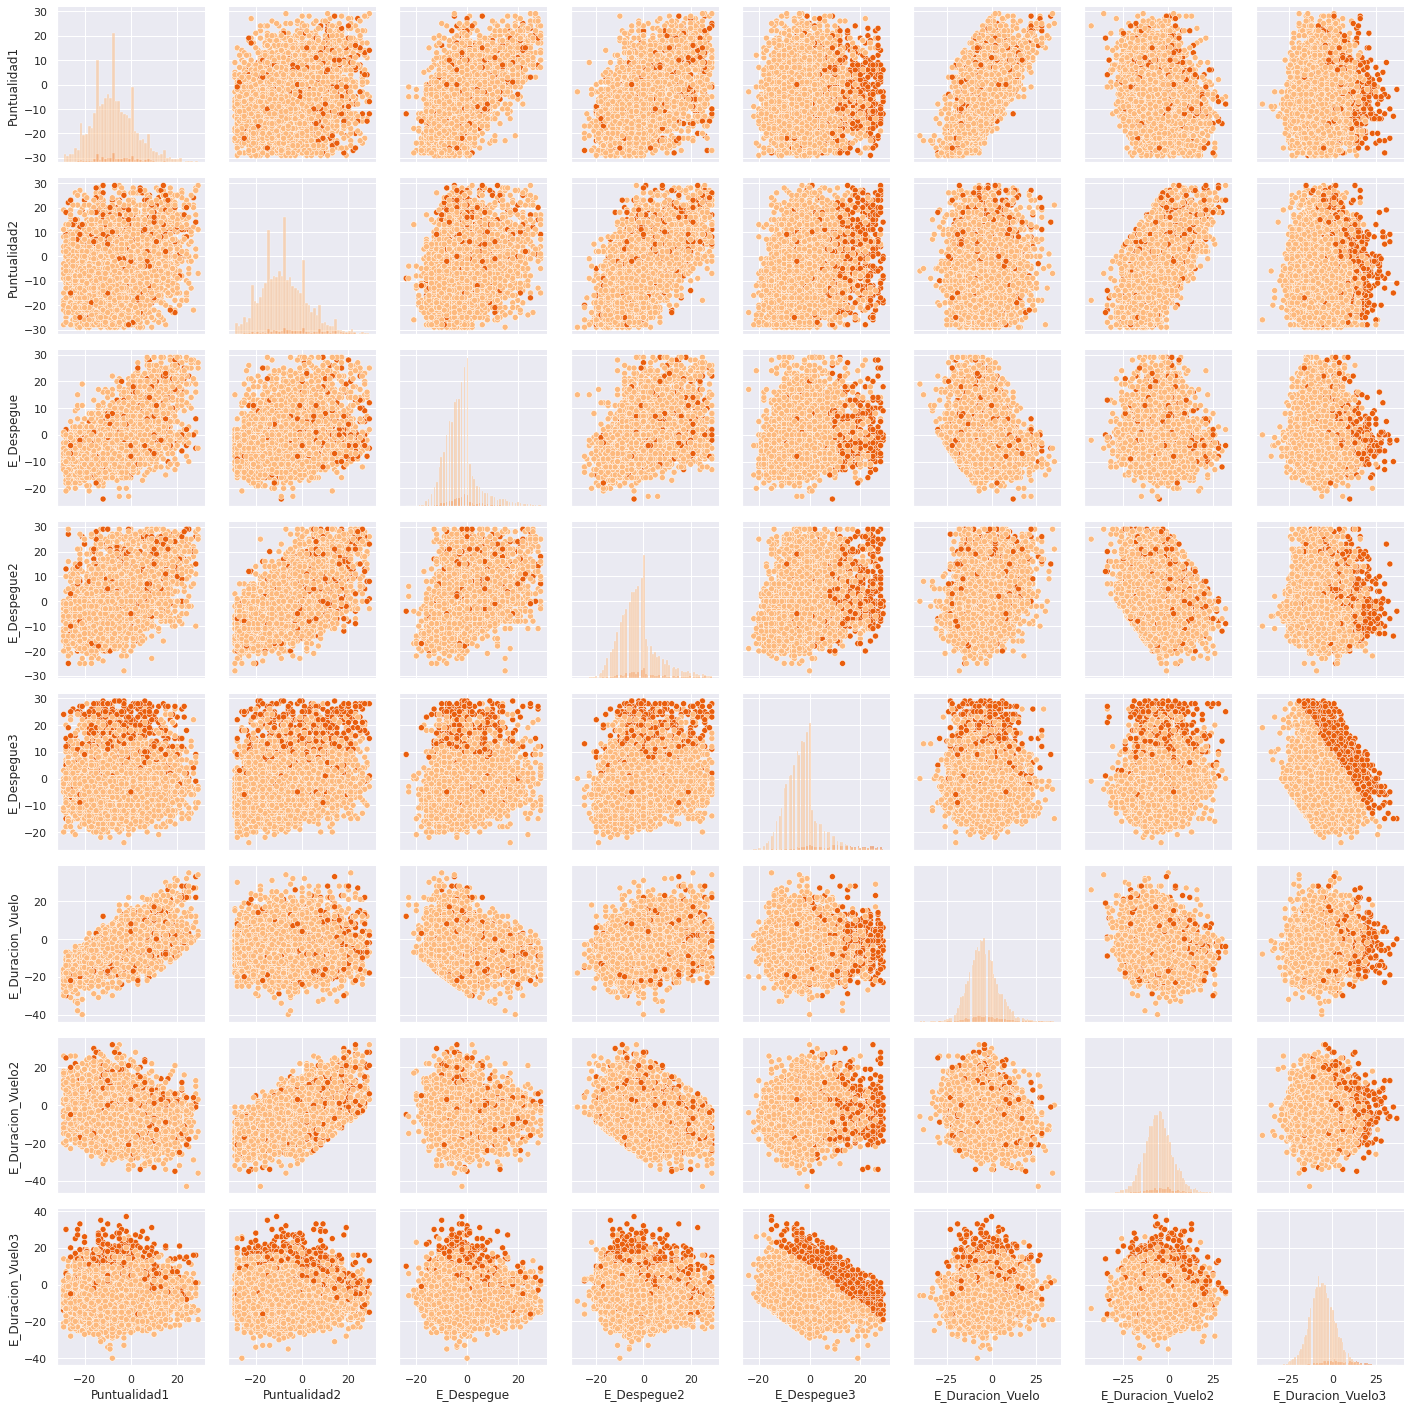

In [385]:
#@title Correlació entre variables
df8=df2.copy()
df8["tardp"] = df8["Tard3"].astype(str)

#df9 = df[dfEliminarOutliers]

df9=df8[['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2',
         'E_Duracion_Vuelo3','Tard3']]


g = sns.PairGrid(df9, hue='Tard3', palette="Oranges")
g.map_diag(sns.histplot, color='blue')
g.map_offdiag(sns.scatterplot, color='black')
#g.refline(x=0, color='red')

PANDAS - Manipulacion de Datos con Python

https://www.google.com/search?q=dataframe+psar+de+numero+a+texto&rlz=1C1WPZA_esES1023ES1023&oq=dataframe+psar+de+numero+a+texto&aqs=chrome..69i57j33i10i160l2.15256j0j7&sourceid=chrome&ie=UTF-8
